# Simple Reinforcement Learning in Tensorflow: Part 1 - Multi-armed Bandit

Following along with this [medium blog](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149) post.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
import tensorflow as tf

Here, we are going to create a 4-armed bandit (mostly because 2 arm converges too fast). The pullBandit function generates a random number from a noral dist with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit that will give that positive reward.

(array([   2.,    2.,   21.,   60.,  159.,  311.,  595.,  963., 1338.,
        1561., 1598., 1296.,  943.,  611.,  306.,  148.,   56.,   23.,
           4.,    3.]),
 array([-3.97621726, -3.5771084 , -3.17799954, -2.77889068, -2.37978182,
        -1.98067296, -1.5815641 , -1.18245524, -0.78334638, -0.38423752,
         0.01487134,  0.4139802 ,  0.81308906,  1.21219792,  1.61130678,
         2.01041564,  2.4095245 ,  2.80863336,  3.20774221,  3.60685107,
         4.00595993]),
 <a list of 20 Patch objects>)

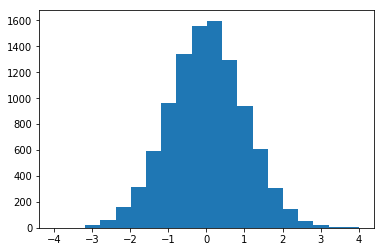

In [2]:
x = np.random.randn(10000)
plt.hist(x, bins=20)

In [3]:
# List our bandits. Currently 4 is set to most often 
# give a positive reward.
bandits = [0.2, 0, -0.2, -5]
num_bandits = len(bandits)
def pullBandit(bandit):
    result = np.random.randn(1)
    if result > bandit:
        return 1
    else:
        return -1    

## The Agent

The code below established our simple neural agent. It consists of a set of values for each of the bandits. Each value is an estimate of the value of the return from choosing the bandit. We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward. 

In [4]:
tf.reset_default_graph()

# Forward
weights = tf.Variable(tf.ones([num_bandits]))
chosen_action = tf.argmax(weights, 0)

# Backward
reward_holder = tf.placeholder(shape=[1], dtype=tf.float32)
action_holder = tf.placeholder(shape=[1], dtype=tf.int32)
responsible_weight = tf.slice(weights, action_holder, [1])
loss = -(tf.log(responsible_weight) * reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
update = optimizer.minimize(loss)

Let's train this bitch! with a $\epsilon$-greedy action decision, we will choose an action, get the reward and run our training with that.

In [5]:
total_episodes = 1000
total_reward = np.zeros(num_bandits)
e = 0.1

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        if np.random.rand(1) < e:
            action = np.random.randint(num_bandits)
        else:
            action = sess.run(chosen_action)
        reward = pullBandit(bandits[action])
        
        #Update the network
        _, resp, ww = sess.run([update, responsible_weight, weights],
                              feed_dict={reward_holder:[reward],
                                         action_holder:[action]})
        
        total_reward[action] += reward
        if i % 50 == 0:
            print "Rewards for the bandits at " + str(i) + ": " + str(total_reward)
        i += 1
    print "The agent thinks bandit " + str(np.argmax(ww)+1) + " is the most promising...."
    if np.argmax(ww) == np.argmax(-np.array(bandits)):
        print "...and it was right!"
    else:
        print "...and it was wrong!"

Rewards for the bandits at 0: [1. 0. 0. 0.]
Rewards for the bandits at 50: [ 0. -2.  2.  1.]
Rewards for the bandits at 100: [ 0. -2. 15.  2.]
Rewards for the bandits at 150: [ 0. -2. 21.  4.]
Rewards for the bandits at 200: [ 1. -1. 39.  6.]
Rewards for the bandits at 250: [ 2. -1. 48.  8.]
Rewards for the bandits at 300: [ 1.  0. 48.  8.]
Rewards for the bandits at 350: [ 0.  0. 50.  9.]
Rewards for the bandits at 400: [ 0. -1. 57.  9.]
Rewards for the bandits at 450: [ 0.  0. 73. 12.]
Rewards for the bandits at 500: [-1. -2. 75. 13.]
Rewards for the bandits at 550: [-1. -4. 89. 15.]
Rewards for the bandits at 600: [ -1.  -5. 100.  15.]
Rewards for the bandits at 650: [ -1.  -5. 103.  16.]
Rewards for the bandits at 700: [ -1.  -4. 126.  16.]
Rewards for the bandits at 750: [ -1.  -6. 138.  16.]
Rewards for the bandits at 800: [ -1.  -7. 154.  17.]
Rewards for the bandits at 850: [ -1.  -7. 162.  17.]
Rewards for the bandits at 900: [  0.  -8. 179.  18.]
Rewards for the bandits at 95

# Contextual Bandits

In the prior exercise, we worked with multi-arm bandits, which really was an action->reward problem. In a full RL problem, we also have a state to deal with. From the state, the model chooses an action that it thinks would provide the best reward (or whatever it's policy is). Along with getting a reward, the action changes the change.  

We are gonna deal with something that's right in the middle. Where we have a state, we choose and action, and get a reward, BUT the action doesn't change the state.

Basically we are going to have multiple bandits, and each bandit is a different state. Since each bandit will have different reward probabilities for each arm, our agent will need to learn to condition its action on the state of the environment. 

In [6]:
class contextual_bandit():
    def __init__(self):
        self.state = 0
        self.bandits = np.array([[0.2,  0, -0.2,  -5],
                                 [0.1, -5,    1, 0.2], 
                                 [ -5,  5,    5,   5]])
        self.num_bandits = self.bandits.shape[0]
        self.num_actions = self.bandits.shape[1]
        
    def getBandit(self):
        self.state = np.random.randint(0, self.num_bandits)
        return self.state
    
    def pullArm(self, action):
        bandit = self.bandits[self.state, action]
        result = np.random.randn(1)
        if result > bandit:
            return 1
        else:
            return -1

## The Agent

We are gonna make a NN for our agent. The input will be the current state, and then we are gonna return an action. 

In [7]:
class agent():
    def __init__(self, lr, s_size, a_size):
        self.state_in = tf.placeholder(shape=[1], dtype=tf.int32)
        onehot = tf.one_hot(self.state_in, s_size)
        output = tf.layers.dense(onehot, a_size, 
                                 use_bias=True, 
                                 activation=tf.nn.sigmoid)
        self.output = tf.reshape(output, [-1])
        self.chosen_action = tf.argmax(self.output, 0)
        
        # Train shiz!
        self.reward_h = tf.placeholder(shape=[1], dtype=tf.float32)
        self.action_h = tf.placeholder(shape=[1], dtype=tf.int32)
        self.resp_wgt = tf.slice(self.output, self.action_h, [1])
        
        self.loss = -(tf.log(self.resp_wgt)*self.reward_h)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
        self.update = optimizer.minimize(self.loss)

Let's train this bitch!

In [8]:
tf.reset_default_graph()

c_Bandit = contextual_bandit()
myAgent = agent(lr=0.001, 
                s_size=c_Bandit.num_bandits,
                a_size=c_Bandit.num_actions)
weights = tf.trainable_variables()[0]

total_episodes = 10000
total_reward = np.zeros([c_Bandit.num_bandits, c_Bandit.num_actions])
e = 0.1

init = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        s = c_Bandit.getBandit()
        if np.random.randn(1) < e:
            action = np.random.randint(c_Bandit.num_actions)
        else:
            action = sess.run(myAgent.chosen_action,
                              feed_dict={myAgent.state_in:[s]})
        reward = c_Bandit.pullArm(action)
        
        # Update the network
        feed_dict = {
            myAgent.reward_h: [reward],
            myAgent.action_h: [action],
            myAgent.state_in: [s]
        }
        _, ww = sess.run([myAgent.update, weights], feed_dict=feed_dict)
        
        total_reward[s, action] += reward
        if i % 500 == 0:
            print "Mean reward for each of the " + str(c_Bandit.num_bandits) + " bandits: " + str(np.mean(total_reward,axis=1))
        i+=1
for a in range(c_Bandit.num_bandits):
    print "The agent thinks action " + str(np.argmax(ww[a])+1) + " for bandit " + str(a+1) + " is the most promising...."
    if np.argmax(ww[a]) == np.argmin(c_Bandit.bandits[a]):
        print "...and it was right!"
    else:
        print "...and it was wrong!"

Mean reward for each of the 3 bandits: [-0.25  0.    0.  ]
Mean reward for each of the 3 bandits: [  1.5   17.25 -32.5 ]
Mean reward for each of the 3 bandits: [  9.    37.75 -67.  ]
Mean reward for each of the 3 bandits: [ 13.25  55.5  -97.5 ]
Mean reward for each of the 3 bandits: [  16.5    75.25 -125.5 ]
Mean reward for each of the 3 bandits: [  19.     95.75 -154.  ]
Mean reward for each of the 3 bandits: [  22.25  112.75 -185.75]
Mean reward for each of the 3 bandits: [  21.5   130.25 -198.5 ]
Mean reward for each of the 3 bandits: [  23.5   148.75 -193.5 ]
Mean reward for each of the 3 bandits: [  27.25  169.   -188.  ]
Mean reward for each of the 3 bandits: [  25.5   187.5  -183.25]
Mean reward for each of the 3 bandits: [  26.75  205.75 -179.25]
Mean reward for each of the 3 bandits: [  27.25  234.25 -169.25]
Mean reward for each of the 3 bandits: [  30.    255.75 -167.5 ]
Mean reward for each of the 3 bandits: [  38.5   274.25 -158.5 ]
Mean reward for each of the 3 bandits: [